**AOL DEEP LEARNING**

Team Member:


1.   2602075491 - Brandon Ritchie Yang
2.   2602081815 - Landry Aidan Liauw
3.   2602084956 - Nicholas Irvin Suhendi




Hubungkan google colab dengan google drive untuk mengambil data image yang sudah ada di dalam google drive.

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


File data merupakan data dalam format ZIP sehingga kami akan membaca dalam format ZIP dan extract semua data ke dalam /content.

In [2]:
# unzip file
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/data_batik.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Import library yang dibutuhkan.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import cv2
import PIL

Define data.

In [4]:
data = '/content/data_batik'

In [5]:
data = pathlib.Path(data)
data

PosixPath('/content/data_batik')

Melihat jumlah data image yang ada.

In [6]:
image_length = len(list(data.glob('*/*.jpg')))
image_length

150

Melihat contoh image dari masing masing kelas.

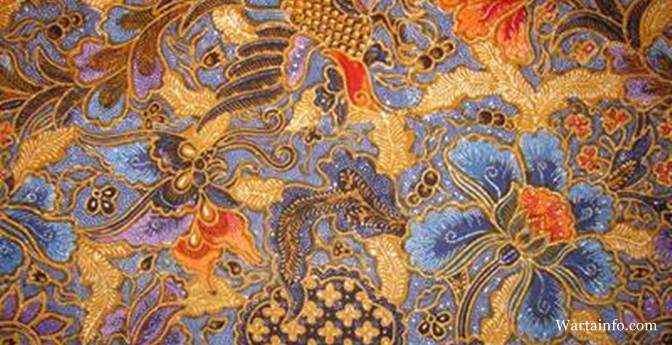

In [7]:
PIL.Image.open(str(list(data.glob('batik-bali/*'))[0]))

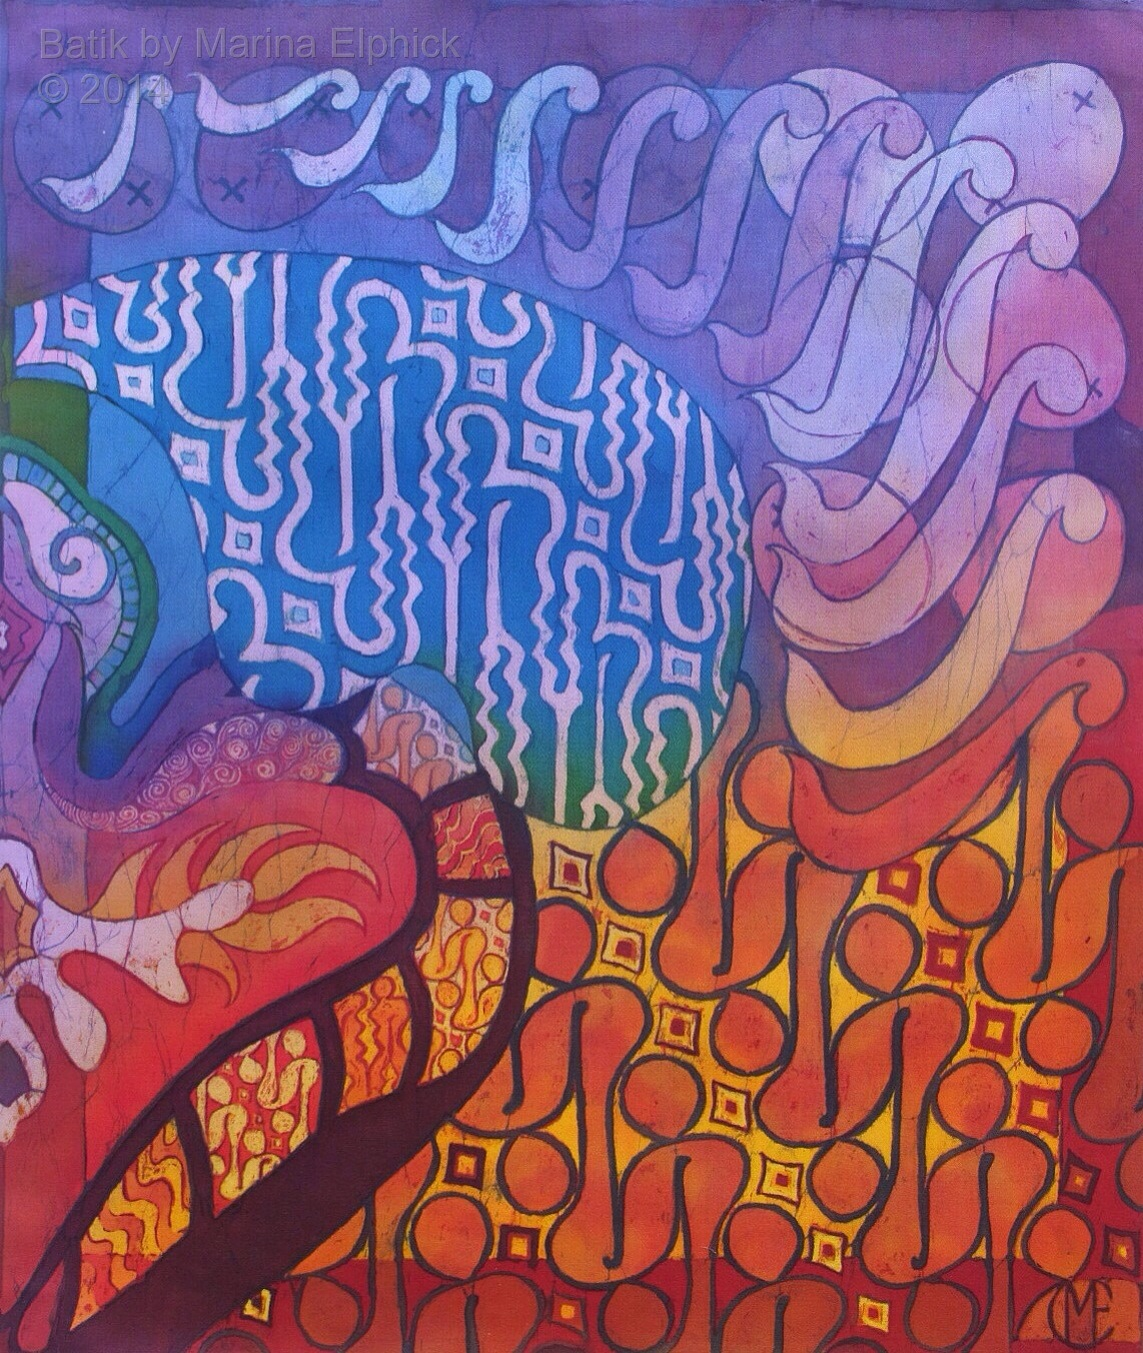

In [8]:
PIL.Image.open(str(list(data.glob('batik-parang/*'))[0]))

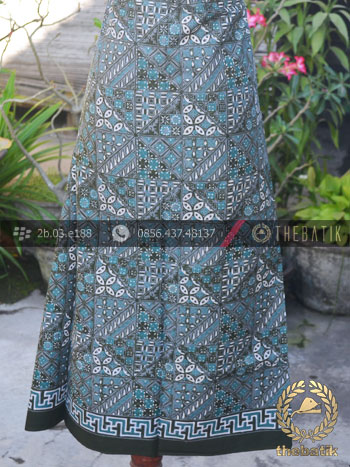

In [9]:
PIL.Image.open(str(list(data.glob('batik-tambal/*'))[0]))

Membagi data image sesuai dengan kelasnya (bali, parang, tambal) dan memberikan label index kepada masing masing kelas. Lalu kami melakukan resize dan juga scaling kepada setiap image satu per satu dan dimasukan ke dalam list X untuk imagenya dan y untuk labelnya, dan jika ditemukan image yang rusak atau tidak bisa dibaca, image tersebut tidak akan di append ke list dan akan diberi tahu bahwa image not found.

In [10]:
batik_image = {
    'bali': list(data.glob('batik-bali/*')),
    'parang': list(data.glob('batik-parang/*')),
    'tambal': list(data.glob('batik-tambal/*'))
}

batik_image_index = {
    'bali': 0,
    'parang': 1,
    'tambal': 2
}

X, y = [], []

for batik_name, images in batik_image.items():
  for image in images:
    img = cv2.imread(str(image))
    if img is not None:
      resized_img = cv2.resize(img, (224, 224))
      resized_img = resized_img / 255.0
      X.append(resized_img)
      y.append(batik_image_index[batik_name])
    else:
      print(f'Image {image} not found')

Image /content/data_batik/batik-parang/47.jpg not found


Mengubah data menjadi 1D array.

In [11]:
X = np.array(X)
y = np.array(y)

Membuat parameter untuk data augmentation. Ada 4 aksi yang dilakukan, yang pertama adalah melakukan random flip secara horizontal dan juga vertical kepada image dan juga menyatakan input shape dari gambar sebesar 224 x 224 x 3 untuk nanti sebagai input di dalam model. Kedua, melakukan rotasi kepada image sebesar sampai dengan 20% secara acak. Ketiga melakukan zoom kepada image sebesar sampai dengan 20% secara acak. Dan yang terakhir melakukan pengaturan kepada kontras dan juga keterangan (brightness) kepada image sebesar sampai dengan 20%.

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

Split data menjadi 70% training, 15% validation, dan 15% testing.

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

print(f'length of x_train: {len(x_train)}')
print(f'length of x_val: {len(x_val)}')
print(f'length of x_test: {len(x_test)}')

length of x_train: 104
length of x_val: 22
length of x_test: 23


Model pertama adalah model dari scratch dimana kami memberi data_augmentation kepada data diawal dan juga memberi input shape sebesar 224 x 224 x 3 di dalam data augmentation seperti yang tadi sudah dijelaskan. Setelahnya memberikan 3 layer, layer pertama dengan 16 filter dengan kernel sebesar 3x3, menggunakan padding same agar width dan height dari image sama dengan input dan menggunakan relu sebagai activation function. Layer kedua dan ketiga juga sama, hanya ada perbedaan di jumlah filternya dimana layer kedua memiliki 32 filter dan layer ketiga memiliki 64 filter. MaxPooling digunakan pada setiap layer untuk mengurangi spatial dimension dan juga untuk mengambil fitur yang dominan. Dropout juga digunakan di setiap layer untuk menghindari overfitting. Setelah 3 layer tersebut ada Flatten yang berfungsi untuk mengubah output yang merupakan 3D menjadi 1D agar bisa dimasukan ke fully connected layer. Setelah itu menambahkan fully connected layer dengan 64 unit dan menggunakan relu untuk activation function. Selanjutnya menggunakan Dropout untuk menghindari overfitting dan yang terakhir ada Fully connected layer lagi dengan 3 unit (jumlah kelas yang ada) dan mmenggunakan activation function softmax dikarenakan output merupakan multi class classification. Selanjutnya model di compile menggunakan optimizer adam untuk mengatur learning rate dalam training, menggunakan sparse categorical crossentropy untuk loss karena data adalah classification dengan label dan metrics accuracy untuk mengevaluasi model.

In [15]:
model_scratch = Sequential([
    data_augmentation,
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')
])

model_scratch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_scratch.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

Setelah melakukan model fitting accuracy yang dihasilkan sebesar sekitar 35% dan validation accuracy sebesar 27%, ketika dilihat dari epoch pertama sampai epoch 10, terpantau accuracy mengalami stuck dan tidak berubah dan ketika di evaluate kepada testing data, model memberikan accuracy sebesar 30%, ini bisa terjadi dikarenakan model yang kurang bagus dan kesulitan untuk mempelajari data yang ada.

In [16]:
history = model_scratch.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/10
4/4 [==============================] - 10s 2s/step - loss: 2.7045 - accuracy: 0.4038 - val_loss: 1.6590 - val_accuracy: 0.2727
Epoch 2/10
4/4 [==============================] - 8s 2s/step - loss: 1.8846 - accuracy: 0.3462 - val_loss: 1.0895 - val_accuracy: 0.2273
Epoch 3/10
4/4 [==============================] - 6s 1s/step - loss: 1.1000 - accuracy: 0.3269 - val_loss: 1.0916 - val_accuracy: 0.2727
Epoch 4/10
4/4 [==============================] - 8s 2s/step - loss: 1.0963 - accuracy: 0.3654 - val_loss: 1.0955 - val_accuracy: 0.3182
Epoch 5/10
4/4 [==============================] - 6s 1s/step - loss: 1.0955 - accuracy: 0.3558 - val_loss: 1.0958 - val_accuracy: 0.2273
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 1.0950 - accuracy: 0.3558 - val_loss: 1.0960 - val_accuracy: 0.2727
Epoch 7/10
4/4 [==============================] - 8s 2s/step - loss: 1.0955 - accuracy: 0.3365 - val_loss: 1.0962 - val_accuracy: 0.2727
Epoch 8/10
4/4 [========================

In [17]:
model_scratch.evaluate(x_test, y_test)

1/1 [==============================] - 0s 299ms/step - loss: 1.1012 - accuracy: 0.3043


[1.101189374923706, 0.30434781312942505]

Selanjutnya kami membuat model lain dengan menggunakan transfer learning menggunakan model MobileNetV2. Pertama kami memberikan data_augmentation kepada model diawal dan memberikan model MobileNetV2 tanpa top layer setelah melakukan augmentation. Setelah itu diberikan GlobalAveragePooling untuk mengurangi jumlah parameter dan membantu untuk menghindari overfitting. Lalu ada fully connected layer dengan 256 unit untuk menggabungkan fitur yang sudah di extract dari model MobileNetV2. Lalu diberikan Dropout sebesar 0.2 untuk menghindari overfitting dan terakhir ada fully connected layer sebesar 3 unit (jumlah kelas) dan softmax sebagai activation function karena output adalah multi class classification. Lalu model di compile menggunakan adam sebagai optimizer dan sparse categorical crossentropy untuk loss function karena data adalah classification dengan label, dan menggunakan metrics accuracy untuk evaluasi model.

In [23]:
from tensorflow.keras.applications import MobileNetV2

model = MobileNetV2(weights = 'imagenet', include_top = False, input_shape=(224, 224, 3))
model.trainable = False

mobilenet_model = Sequential([
    data_augmentation,
    model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation = 'softmax')
])

mobilenet_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
mobilenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

Setelah melakukan model fitting, accuracy dari model ini mencapai 93.27% dan validation accuracy mencapai sekitar 82%. Dalam training, model memberikan peningkatan yang lumayan bagus dan stabil dalam accuracy dan loss sampai diakhir training, ini menandakan model belajar dari data training dengan bagus. Dalam validation, model memberikan accuracy yang lumayan naik turun di sekitar 81% sampai 86% dan loss nya tidak konsisten menurun, ini bisa menandakan adanya overfitting. Dalam testing, accuracy yang diperoleh adalah sebesar 82.6% dimana ini mirip dengan accuracy data validation dimana ini menandakan bahwa model cukup berhasil dalam belajar data yang tidak terlihat tetapi model masih bisa dikatakan sedikit overfitting dikarenakan alasan validation tadi. Secara keseluruhan model bisa dibilang cukup bagus tetapi memiliki sedikit overfitting, ini bisa dikarenakan data yang kurang banyak atau data yang kurang bagus, seperti pada data pada batik tambal yang menampilkan batik dalam bentuk baju, bukan dalam bentuk kain yang full page.

In [24]:
history2 = mobilenet_model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/10
4/4 [==============================] - 14s 3s/step - loss: 1.1202 - accuracy: 0.4808 - val_loss: 0.7410 - val_accuracy: 0.6818
Epoch 2/10
4/4 [==============================] - 6s 2s/step - loss: 0.6801 - accuracy: 0.6923 - val_loss: 0.4633 - val_accuracy: 0.9091
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 0.4600 - accuracy: 0.7788 - val_loss: 0.4671 - val_accuracy: 0.8636
Epoch 4/10
4/4 [==============================] - 6s 1s/step - loss: 0.4118 - accuracy: 0.8173 - val_loss: 0.5154 - val_accuracy: 0.7727
Epoch 5/10
4/4 [==============================] - 6s 2s/step - loss: 0.3559 - accuracy: 0.8942 - val_loss: 0.4070 - val_accuracy: 0.8182
Epoch 6/10
4/4 [==============================] - 7s 2s/step - loss: 0.3027 - accuracy: 0.8750 - val_loss: 0.3531 - val_accuracy: 0.8636
Epoch 7/10
4/4 [==============================] - 5s 1s/step - loss: 0.2726 - accuracy: 0.8942 - val_loss: 0.3849 - val_accuracy: 0.8182
Epoch 8/10
4/4 [========================

In [25]:
mobilenet_model.evaluate(x_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.7496 - accuracy: 0.8261


[0.7495697140693665, 0.8260869383811951]